# TP 8 : Support Vector Machine

# <div class="alert alert-block alert-success">
<b>Informations générales </b>
</div>

**Professeur**: Stephan Robert

**Assistant(s)**: Félicien Hêche

**Contact**: stephan.o.robert@gmail.com, felicien.heche@gmail.com ou via Teams

**Rendu**:

- Modalité: Travail individuel. Une fois complétées, copiez les réponses dans le ficher "**TP8_APV_S1-2023_Nom_Prenom.*****" (*** = ce que vous voulez qui soit lisible pour nous: .pdf, .html, ...) en remplaçant Nom et Prenom par les votres puis uploader votre fichier sur Cyberlearn.
- Note: Ce TP est noté sur 6, pour un poids de x%

**Étudiant**:

- Hugo Huart

<div class="alert alert-block alert-success">

<b>But du TP </b>
</div>

Le but de ce travail pratique sera d'implémenter SVM.


<!---
<div class="alert alert-block alert-info">
<b>Rappel </b>
</div>
-->

<div class="alert alert-block alert-success">
<b>Table des matières </b>
</div>

1. Data préparation
2. Naïve SVM
3. Kernel SVM

Comme d'habitude, commençons par importer quelques packages.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn import svm

## 1 Data préparation

Pour commencer, on va générer un dataset synthétique.

In [75]:
# Label == 1
mean = [10, 10]
cov = np.eye(2)
X = np.random.multivariate_normal(mean, cov, size=100)
Y = np.ones(100)

# Label == -1
mean = [0, 0]
X_1 = np.random.multivariate_normal(mean, cov, size=100)
Y_1 = -np.ones(100)

X_train = np.concatenate([X, X_1], axis=0)
Y_train = np.concatenate([Y, Y_1], axis=0)

Ensuite, on va faire un plot de ces données, pour avoir une idée de leur distribution.

<Axes: >

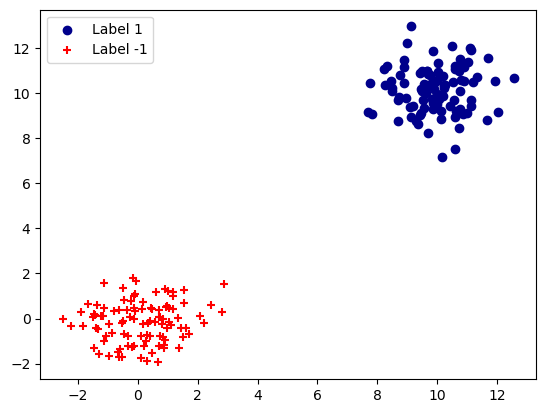

In [76]:
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], label="Label 1", c="darkblue")
ax.scatter(X_1[:, 0], X_1[:, 1], marker="+", label="Label -1", c="red")

plt.legend()
plt.subplot()

## 2. Naïve SVM

Passons aux choses sérieuses. On peut mainteant construire notre propre implémentation de SVM!

Pour simplifier, et comme le dataset avec lequel nous travaillons est linéairement séparable, nous allons implémenter la version naïve de SVM. On peut donc réécrire notre problème de la manière suivante.
$$
\begin{aligned}
\text{Min} & \quad \frac{\| w \|^{2}_{2}}{2} \\
& y_{i} (w^{T}x_{i} + b) \geq 1 \quad \forall i \\
\end{aligned}
$$

Pour maximiser cette fonction objective, plusieurs méthodes sont possibles. Mais ici, nous proposons d'utiliser optimize.minimize du package scipy.

Pour commencer, remarquer que pour $M$  suffisamment grand, le problème présenté ci-dessus est équivalent
à
$$\text{Min} \quad \frac{\| w \|^{2}_{2}}{2} + \sum_{i=1}^{n} M  \max \{ 0, 1 - y_{i}(w^{T}x_{i} + b) \}$$
Par conséquent, afin de trouver les paramètre de notre SVM, il suffit de trouver les paramètres qui minimise l'équation ci-dessus.

Assurez-vous d'avoir bien compris pourquoi ces deux problèmes sont équivalents. N'hésitez pas à poser des questions dans le cas contraire. 


Après ces considérations théorique, on peut passer à l'implémentation de notre SVM.

In [77]:
class NaiveSVM:
    """
    An implementation of a naïve SVM
    """

    def _f(self, M, w, b):
        return np.linalg.norm(w)**2 / 2 + np.sum(M * np.maximum(0, 1 - self.Y * (np.dot(self.X, w) + b)))
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

        # [w0, w1, ..., w_n, b]
        self.params = np.random.rand(len(self.X[0]) + 1)

    def optimize(self):
        M = np.max(self.X) * 10
        opt = optimize.minimize(lambda params: self._f(M, params[0:-1], params[-1]), self.params, method="Nelder-Mead")
        self.params = opt.x

    def predict(self):
        w = self.params[:-1]
        b = self.params[-1]

        return np.sign(np.dot(self.X, w) + b)

    def plot_svm(self):
        if len(self.X[0]) != 2:
            print("Only 2D data is plottable")
            return

        fig, ax = plt.subplots()

        x = self.X[self.Y == 1]
        x1 = self.X[self.Y == -1]
        
        ax.scatter(x[:, 0], x[:, 1], c="darkblue", label="Label 1")
        ax.scatter(x1[:, 0], x1[:, 1], c="red", label="Label -1", marker="+")
        
        # y = (-a / b) * x + (-c / b)
        w, b = self.params[0:-1], self.params[-1]
        ax.axline((0, -b / w[1]), slope=(-w[0] / w[1]), c="black", label="Hyperplan")

        plt.legend(loc="best")
        plt.plot()

Maintenant que cette classe a été construite nous allons l'utiliser afin de visualiser le seuil de décision de notre modèle. Tout d'abord visualisation notre modèle avant l'entraînement.

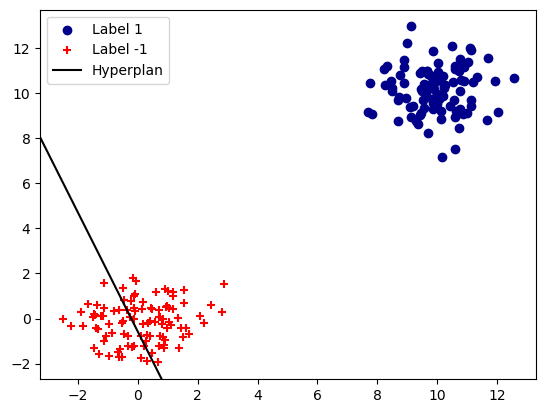

In [78]:
model = NaiveSVM(X_train, Y_train)
model.plot_svm()

Et après l'entraînement, nous obtenons.

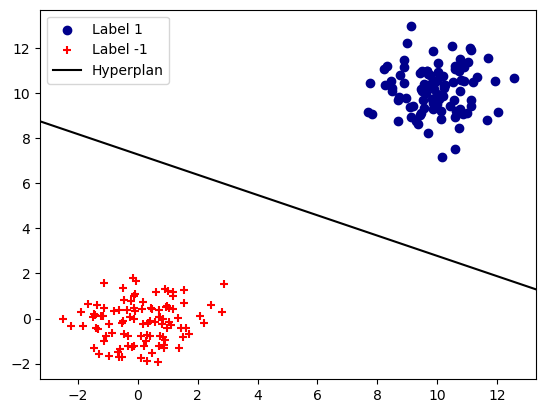

In [79]:
model.optimize()
model.plot_svm()

## 3. Kernel SVM

Notre implémentation de SVM construite ci-dessus, nous permet de travailler dans le cas où les classes sont linéairement séparables. 
En pratique, il est évident que cette condition n'est que très rarement vérifiée. Pour contourner cette limitation et comme présenté dans la partie théorique de ce travail, il est courant de permettre à notre plan de ne pas classifier correctement quelques données.


Cependant, notre classificateur va rester un plan et dans certain cas cela peut être très limitant. Par exemple, considérons le dataset suivant.

In [80]:
with open('ex3data.txt') as f2:
    dataset_2 = np.loadtxt(f2, delimiter = ',',dtype = 'float', usecols = None)

X = dataset_2[:, :-1]
Y = dataset_2[:, 2]
KO = np.where(Y == 0)[0]
OK = np.where(Y)[0]

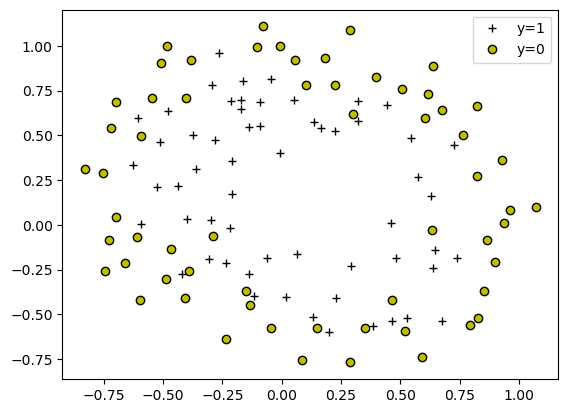

In [81]:
# plot
plt.figure()
plt.plot(X[OK, 0], X[OK, 1], 'k+')
plt.plot(X[KO, 0], X[KO, 1], 'ko', markerfacecolor='y')

plt.legend(['y=1', 'y=0'])
plt.show()

Ce plot nous permet de remarquer que même en autorisant quelques erreurs, il sera compliqué de trouver un plan qui sépare nos deux classes de manière pertinentes.

Pour essayer de résoudre ce problème, il est courant d'utiliser une astuce appelée astuce du noyau (kernel trick). Ce technique consiste à plonger nos données dans un espace dans lequel les données sont linéairement séparables et utiliser SVM dans cet espace. Nous n'allons pas entrer dans les détails sur la manière dont cela est fait en pratique, vous pouvez trouver facilement de la documentation à ce sujet, mais de nombreuses implémentations de SVM permettent d'utiliser cette astuce du noyau.



Dans la suite de travail, nous allons construire quelques SVM en utilisant plusieurs astuces du noyau. 

In [82]:
def build_plot_kernel_svm(X, Y, kernel='linear', show=True):
    """
    Build a kernel SVM, train it using X, Y, plot the data and the decision boundary
    if the keyword show is set to True.
    """
    clf = svm.SVC(kernel=kernel)
    clf.fit(X, Y)

    if show:
        fig, ax = plt.subplots()

        OK = Y == 1
        KO = Y != 1

        x1, x2 = np.min(X[:, 0]), np.max(X[:, 0])
        y1, y2 = np.min(X[:, 1]), np.max(X[:, 1])
        dimcount = 50

        U, V = np.meshgrid(np.linspace(x1, x2, dimcount), np.linspace(y1, y2, dimcount))
        Z = clf.decision_function(np.column_stack([U.ravel(), V.ravel()])).reshape(U.shape)

        ax.set_xlim(-1, 1.5)
        ax.set_ylim(-0.75, 1.2)

        y1, = ax.plot(X[OK, 0], X[OK, 1], 'k+')
        y0, = ax.plot(X[KO, 0], X[KO, 1], 'ko', markerfacecolor='y')
        c1, _ = ax.contour(U, V, Z, levels=[0]).legend_elements()

        ax.set_title(f"kernel = {kernel}")
        ax.legend([y1, y0, c1[0]], ["y=1", "y=0", "Decision Boundary"])
        plt.plot()

En utilisant cette fonction, nous pouvons alors comparer différents modèles.

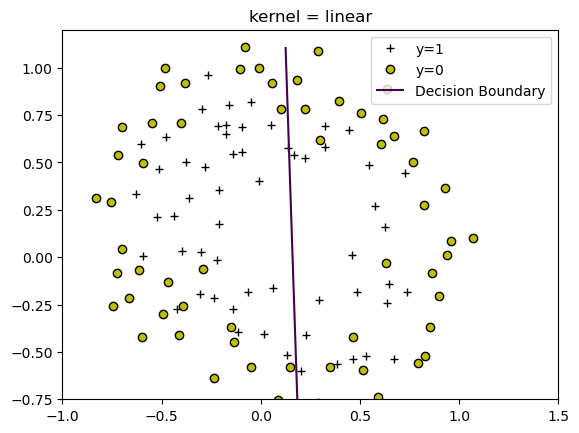

In [83]:
# kernel='linear' corresponds to the classic SVM
build_plot_kernel_svm(X=X, Y=Y, kernel='linear', show=True)

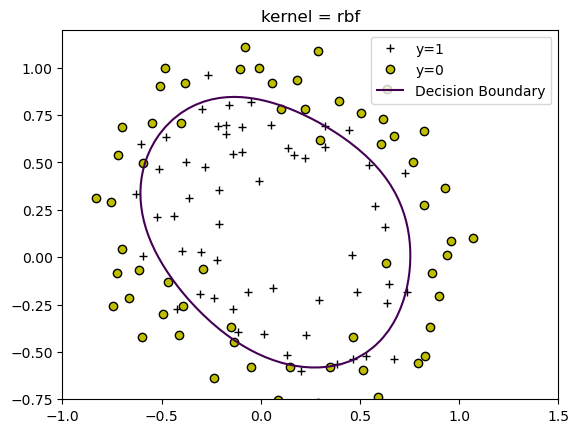

In [84]:
build_plot_kernel_svm(X=X, Y=Y, kernel='rbf', show=True)

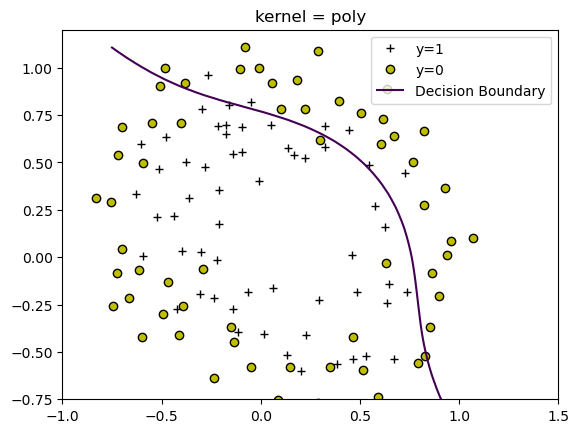

In [85]:
build_plot_kernel_svm(X=X, Y=Y, kernel='poly', show=True)

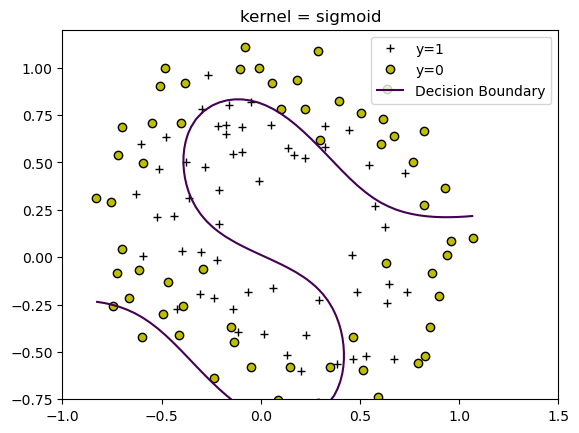

In [86]:
build_plot_kernel_svm(X=X, Y=Y, kernel='sigmoid', show=True)